In [ ]:
using BenchmarkTools
using Plots

include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

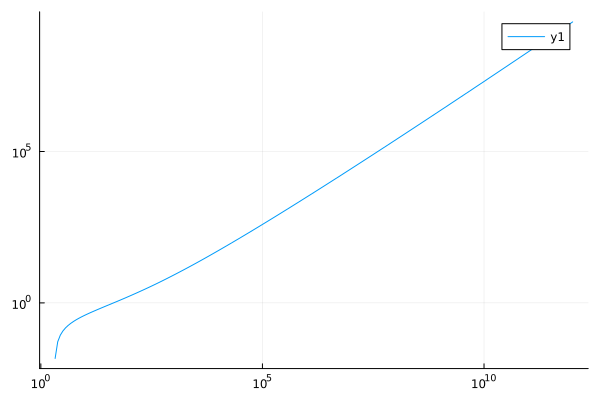

In [6]:
using Plots

Mhost_init = 1e+12
Mres = 1e+0

s_vs_m, ds_vs_m = cj.interpolation_s_vs_mass()

Mhost = 10.0.^range(log10(2.1*Mres), log10(Mhost_init), 200)

#function_P, function_F = cj.interpolate_functions_PF(Mhost_init, Mres)

plot(Mhost, cj.mean_number_progenitors.(Mhost/2.0, Mhost, Mres, s_vs_m, ds_vs_m), xscale=:log10,  linestyle=:solid, yscale=:log10)
#plot!(Mhost, function_P.(Mhost, Mres), xscale=:log10, linestyle=:dash, linewidth=4, yscale=:log10)

0.2339008164327821


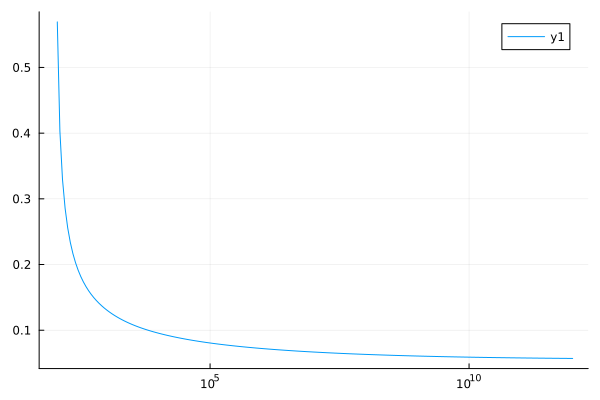

In [175]:
using Plots

mhost = 1e+12
mres = 1e+2

m = 10.0.^range(log10(mres), log10(mhost), 200)

s_vs_m, _ = cj.interpolation_s_vs_mass()
#function_P, function_F = cj.interpolate_functions_PF(mhost, mres)

println(cj.mass_fraction_unresolved.(2e+2, 1e+2, s_vs_m))

plot(m, cj.mass_fraction_unresolved.(m, mres, s_vs_m), xscale=:log10,  linestyle=:solid)
#plot!(m, function_F.(m), xscale=:log10, linestyle=:dash, linewidth=4)

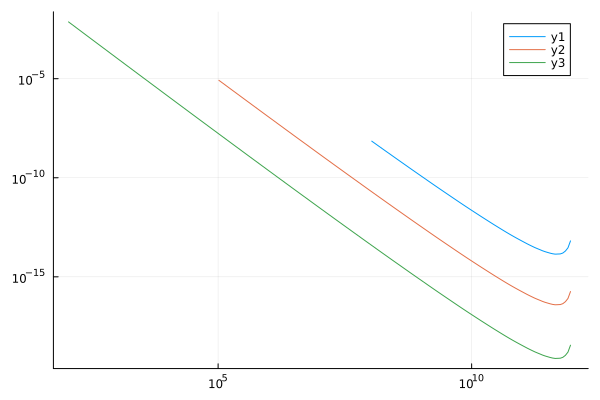

In [7]:
using Plots

M1   = 1e+12
M2 = 10.0.^range(2, log10(M1), 200)

s_vs_m, ds_vs_m = cj.interpolation_s_vs_mass()

plot(M2[M2.>1e+8], cj.pdf_progenitors.(M2[M2.>1e+8], M1, 1e+8, s_vs_m, ds_vs_m), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+5], cj.pdf_progenitors.(M2[M2.>1e+5], M1, 1e+5, s_vs_m, ds_vs_m), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+2], cj.pdf_progenitors.(M2[M2.>1e+2], M1, 1e+2, s_vs_m, ds_vs_m), xscale=:log10, yscale=:log10)

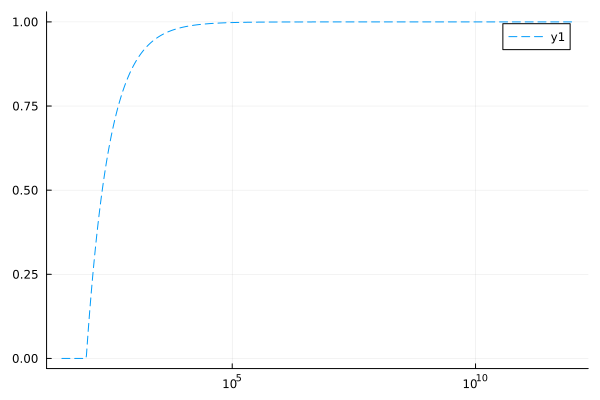

In [241]:
using Plots


s_vs_m, ds_vs_m = cj.interpolation_s_vs_mass()

M1   = 1e+12
M2 = 10.0.^range(0, log10(M1), 100)

#plot(M2, cj.cmf_progenitors.(M2, M1, 1e+8) .- 0.2, xscale=:log10)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+5).- 0.2, xscale=:log10)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+2).- 0.2, xscale=:log10)

M1   = 1e+12
M2 = 10.0.^range(1.5, log10(M1), 1000)

#plot(M2, cj.cmf_progenitors.(M2, M1, 1e+8).- 0.2, xscale=:log10, linestyle=:dash)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+5).- 0.2, xscale=:log10, linestyle=:dash)
plot(M2, cj.cmf_progenitors.(M2, M1, 1e+2, s_vs_m, ds_vs_m), xscale=:log10, linestyle=:dash)

In [ ]:
itp_z_vs_Δω = cj.interpolate_functions_z()

In [ ]:
subhalo_mass1, m_host1, z_steps1, z_acc1 = cj.subhalo_mass_function(1e+12, 1e+8, z_vs_Δω = itp_z_vs_Δω)

In [ ]:
subhalo_mass2, m_host2, z_steps2, z_acc2 = cj.subhalo_mass_function(1e+12, 1e+5, z_vs_Δω = itp_z_vs_Δω)

In [ ]:
subhalo_mass3, m_host3, z_steps3, z_acc3 = cj.subhalo_mass_function(1e+12, 1e+6,  z_vs_Δω = itp_z_vs_Δω)

In [ ]:
using Plots

m_array = 10.0.^range(-8, stop=1, length=1000)
#CMF1 = [count(x -> x > m, subhalo_mass1) for m in m_array]
CMF2 = [count(x -> x > m, subhalo_mass2) for m in m_array]
CMF3 = [count(x -> x > m, subhalo_mass3) for m in m_array]

#plot(m_array[CMF1 .> 0], CMF1[CMF1 .> 0], xscale=:log10, yscale=:log10, color=:blue)
plot(m_array[CMF2 .> 0], CMF2[CMF2 .> 0], xscale=:log10, yscale=:log10, color=:red)
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, color=:green)

In [ ]:
using SpecialFunctions
using LsqFit

function γ2(γ1::Real, α1::Real, α2::Real, β::Real, ζ::Real) 
    int1 =  β.^(.-(2.0.-α1)./ζ) .* gamma.((2.0.-α1)./ζ) .*  gamma_inc.((2.0.-α1)./ζ, β)[1] ./ ζ 
    int2 =  β.^(.-(2.0.-α2)./ζ) .* gamma.((2.0.-α2)./ζ) .*  gamma_inc.((2.0.-α2)./ζ, β)[1] ./ ζ 
    return (1.0 .- γ1 .* int1) ./  int2
end

function fitting_function(m_m0, γ1, α1, α2, β, ζ)
    if α1 > 2 || α1 < 1 || α2 > 2 || α2 < 1 || β < 0 || ζ < 0 || γ1 < 0
        return Inf
    end
    return γ1./ζ .* ((m_m0).^(1.0.-α1) .* expint.((α1.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α1.-1.0)./ζ .+ 1.0, β)) .+  γ2(γ1, α1, α2, β, ζ)./ζ .* ((m_m0).^(1.0.-α2) .* expint.((α2.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α2.-1.0)./ζ .+ 1.0, β)) 
end

p0 = [0.019, 1.94, 1.58, 24, 3.4]

model(t, p) = @. log10.(fitting_function(10.0.^t, p[1], p[2], p[3], p[4], p[5]))

fit = curve_fit(model, log10.(m_array[CMF3 .> 0]), log10.(CMF3[CMF3 .> 0]), p0)

println(fit.param)
println(γ2(fit.param...))

res = 10.0.^model(log10.(m_array), fit.param) #fitting_function(1e+12 .* m_array, 1e+12, fit.param...)
plot(m_array[res .> 0], res[res .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])

In [ ]:
#plot(z_steps1, m_host1, yscale=:log10, color=:blue)
plot(z_steps2, m_host2, yscale=:log10, color=:red)
plot!(z_steps3, m_host3, yscale=:log10, color=:green)

In [ ]:
#plot(subhalo_mass1, z_acc1, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)
plot(subhalo_mass2, z_acc2, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)
plot!(subhalo_mass3, z_acc3, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)

In [ ]:
import StatsBase as SB
using Plots

id_6 = (subhalo_mass2 .> 1e-6) .& (subhalo_mass2 .< 1e-5)
id_5 = (subhalo_mass2 .> 1e-5) .& (subhalo_mass2 .< 1e-4)
id_4 = (subhalo_mass2 .> 1e-4) .& (subhalo_mass2 .< 1e-3)
id_3 = (subhalo_mass2 .> 1e-3) .& (subhalo_mass2 .< 1e-2)
#println(count(x -> x === true, id_4))

#result6 = SB.fit(Histogram, log10.(z_acc3[id_6]), nbins=40)
#result5 = SB.fit(Histogram, log10.(z_acc3[id_5]), nbins=40)
#plot(result6.edges[1][2:end], log10.(result6.weights), st=:stairs)
#plot!(result5.edges[1][2:end], log10.(result5.weights), st=:stairs)

histogram(log10.(z_acc2[id_6]), normalize=:pdf)
histogram!(log10.(z_acc2[id_5]), normalize=:pdf)
histogram!(log10.(z_acc2[id_4]), normalize=:pdf)

In [242]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

mres = 1e+3
mhost = 1e+12

cj.save_data_merger_tree(mhost, mres)

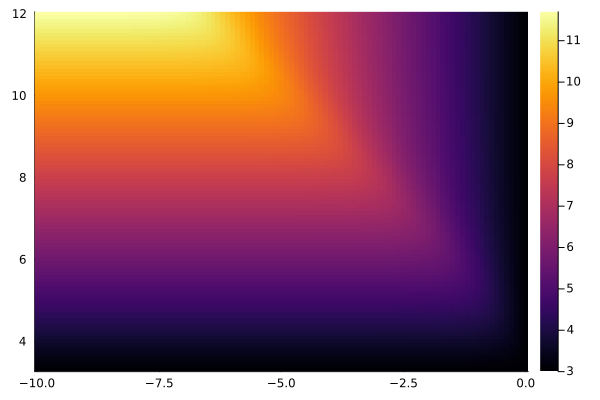

In [243]:
using Plots

q = range(-10, 0, length=101)
m1_array = 10.0.^range(log10(2.0001*mres), log10(mhost), length=101)

func, _, _ = cj.load_data_merger_tree(mhost, mres)
plot(heatmap(q, log10.(m1_array), log10.(func.((1.0 .- 10.0.^q)', m1_array))), c = :thermal)

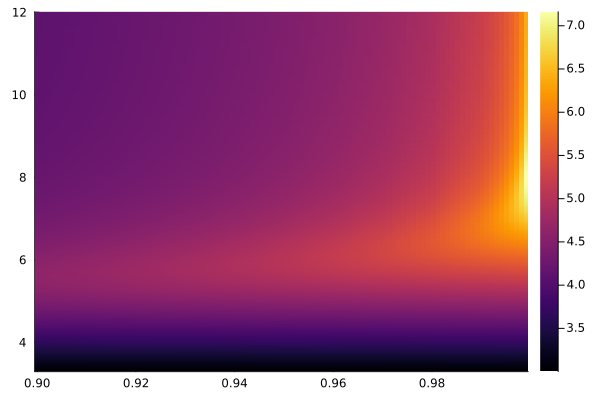

In [244]:
using Plots

p = range(0.9, 0.999, length=101)
m1_array = 10.0.^range(log10(2.0001*mres), log10(mhost), length=401)

func, _, _ = cj.load_data_merger_tree(mhost, mres)
plot(heatmap(p, log10.(m1_array), log10.(func.(p', m1_array))), c = :thermal)

In [266]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

using Random

Random.seed!(3)

itp_z_vs_Δω = cj.interpolate_functions_z()

z_bins, mass_edges, z_edges = cj.subhalo_mass_function_binned(1e+12, 1e+3, z_vs_Δω = itp_z_vs_Δω)

┌ Info: ===========================================
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:396
┌ Info: INITIALISATION
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:397
┌ Info: | Precomputing or loading the interpolation tables
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:398
┌ Info: | file to save is already cached
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:177


┌ Info: INITIALISATION DONE: STARTING MERGER TREE
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:418
┌ Info: ("| i = ", 3548133, ", z = ", 0.12275362919664716, ", n_sub = ", 355134)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


┌ Info: ("| i = ", 7096266, ", z = ", 0.24526236048935227, ", n_sub = ", 710127)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446
┌ Info: ("| i = ", 10644399, ", z = ", 0.3659554046612608, ", n_sub = ", 1065168)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


┌ Info: ("| i = ", 14192532, ", z = ", 0.5161505330679435, ", n_sub = ", 1419238)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446
┌ Info: ("| i = ", 17740665, ", z = ", 0.6826051805966273, ", n_sub = ", 1773678)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


┌ Info: ("| i = ", 21288798, ", z = ", 0.8504790711531716, ", n_sub = ", 2128767)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446
┌ Info: ("| i = ", 24836931, ", z = ", 1.022995787625857, ", n_sub = ", 2483952)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


┌ Info: ("| i = ", 28385064, ", z = ", 1.2102948250449252, ", n_sub = ", 2838588)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446
┌ Info: ("| i = ", 31933197, ", z = ", 1.535504327328388, ", n_sub = ", 3193757)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


┌ Info: ("| i = ", 35481330, ", z = ", 1.9716073981859574, ", n_sub = ", 3547572)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446
┌ Info: ("| i = ", 39029463, ", z = ", 2.5179975496131357, ", n_sub = ", 3902690)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


┌ Info: ("| i = ", 42577596, ", z = ", 3.1807445477926475, ", n_sub = ", 4257388)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446
┌ Info: ("| i = ", 46125729, ", z = ", 4.0701259784057795, ", n_sub = ", 4612881)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


┌ Info: ("| i = ", 49673862, ", z = ", 6.19973865472953, ", n_sub = ", 4967645)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:446


MERGER TREE OVER
| 50778231 interations were done
| final redshift : 39.11077051472117
| 5078308 subhalos found


(UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000], [1.0e-9, 1.2589254117941663e-9, 1.584893192461111e-9, 1.9952623149688828e-9, 2.511886431509582e-9, 3.1622776601683795e-9, 3.981071705534969e-9, 5.011872336272715e-9, 6.309573444801943e-9, 7.943282347242822e-9  …  0.12589254117941673, 0.15848931924611134, 0.19952623149688797, 0.251188643150958, 0.31622776601683794, 0.39810717055349726, 0.5011872336272722, 0.6309573444801932, 0.7943282347242815, 1.0], [1.0e-9, 1.7113283041617775e-9, 2.9286445646252374e-9, 5.011872336272715e-9, 8.576958985908947e-9, 1.4677992676220705e-8, 2.511886431509582e-8, 4.298662347082281e-8, 7.356422544596406e-8, 1.2589254117941662e-7  …  794.3282347242813, 1359.3563908785254, 2326.3050671536

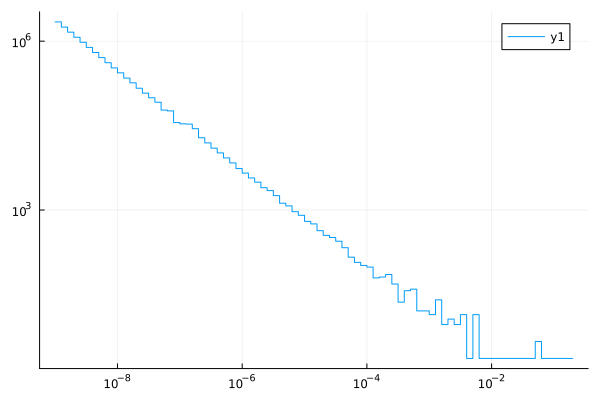

In [267]:
using Plots

mass_bins = sum(z_bins, dims=2)[:]
edges = mass_edges[1:end-1][mass_bins .> 0]

plot(edges,  log(10) .* mass_bins[mass_bins .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)

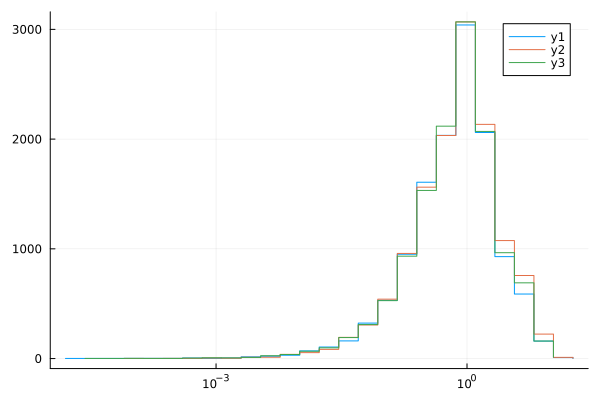

In [261]:
using Plots

im = searchsortedfirst(mass_edges, 1e-7)

#mass_edges[21]

edges = z_edges[1:end-1]
data1 = z_bins[im,:]
data2 = z_bins[im-1,:]
data3 = z_bins[im+1,:]

plot(edges[data1 .> 0], data1[data1 .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)
plot!(edges[data2 .> 0], data2[data2 .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)
plot!(edges[data3 .> 0], data3[data3 .> 0], xscale=:log10, yscale=:identity, seriestype=:stairs)

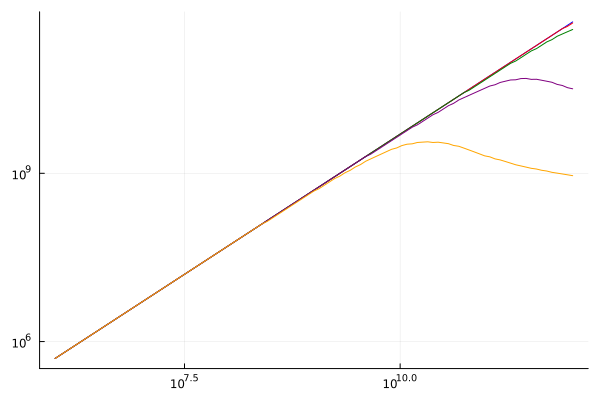

In [139]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

m1_array = 10.0.^range(log10(1e+6), log10(mhost), length=101)
res1 = cj.cmf_inv_progenitors.(0.9999999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res2 = cj.cmf_inv_progenitors.(0.999999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res3 = cj.cmf_inv_progenitors.(0.99999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res4 = cj.cmf_inv_progenitors.(0.9999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res5 = cj.cmf_inv_progenitors.(0.999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)

plot(m1_array[res1 .> 0], res1[res1 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:blue)
plot!(m1_array[res2 .> 0], res2[res2 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:red)
plot!(m1_array[res3 .> 0], res3[res3 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:green)
plot!(m1_array[res4 .> 0], res4[res4 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:purple)
plot!(m1_array[res5 .> 0], res5[res5 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:orange)

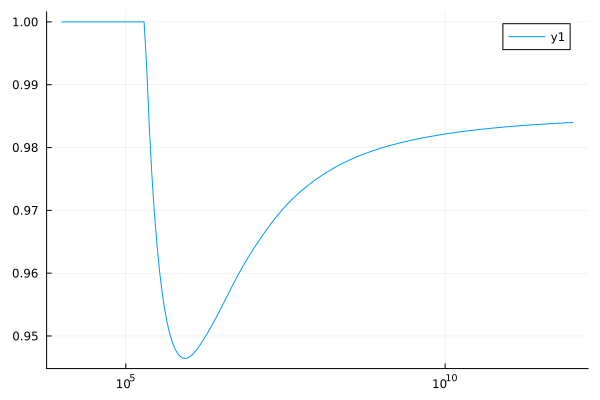

In [271]:
m_range = 10.0.^range(log10(1e+4), 12, 200)

s_vs_m, dS_vs_m = cj.interpolation_s_vs_mass()
plot(m_range, cj.cmf_progenitors.(1e+5, m_range, 1e+3, s_vs_m, dS_vs_m ), xscale=:log10)



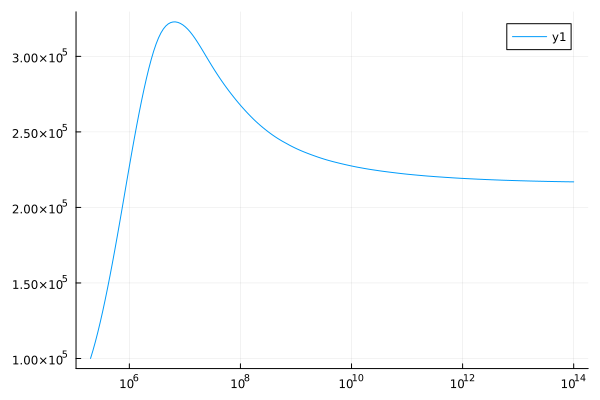

In [294]:
s_vs_m, dS_vs_m = cj.interpolation_s_vs_mass()

m_range = 10.0.^range(log10(2.001e+5), 14, 200)

plot(m_range, cj.cmf_inv_progenitors.(0.5, m_range, 1e+5, s_vs_m, dS_vs_m), xscale=:log10)

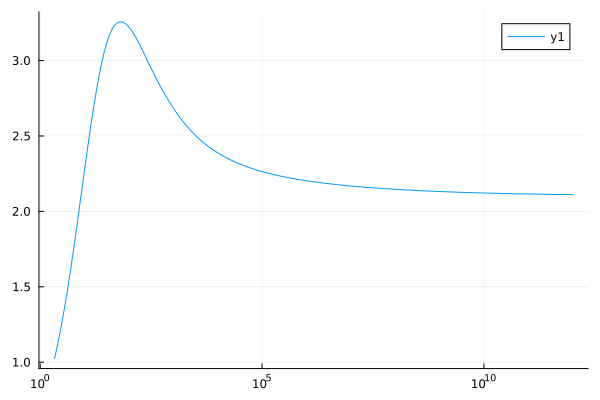

In [296]:
s_vs_m, dS_vs_m = cj.interpolation_s_vs_mass()

m_range = 10.0.^range(log10(2.1e+0), 12, 200)

plot(m_range, cj.cmf_inv_progenitors.(0.5, m_range, 1e+0, s_vs_m, dS_vs_m), xscale=:log10)
#println(cj.cmf_inv_progenitors.(0.5, 1e+5, 1e+3, s_vs_m, dS_vs_m))
#println(func(0.12112736878992725, 2.4e+3))